# Common ML Algorithms in One Notebook
The purpose of this All-in-one Notebook is to illustrate the modelling workflow of common ML techniques (Processing, Modeling, Predicting, Evaluating).
The tuning is not focused. You are recommended to do further research on it.

There are 2 main problems in ML:
* **Regressions**: Predicting a quantity (In this example: `yearly_amount_spent`)
* **Classifications**: Predicting a class (For example: High-value users with `yearly_amount_spent` > q0.8)

> *Note: Though it might not show in this notebook: SVM, Boosting (XGBoost, GBM, LightGBM), Tree-based (Decision-Tree, Random Forest) => Can work on borht problems with Regressor and Classifier, respectively (Fore example, in this notebook `XGBRegressor` and `XGBClassifier`*

There are 3 main types of ML algorithms:
1. **Supervised Learning**: Have an observed label/target/outcome to be predicted from a set of predictors. We generate a functions to map inputs to the desired outputs (Linear Regressions, RF, XGBoost, etc). There are 2 main problems in ML:
    - Regressions: Predicting a quantity - For example: `yearly_amount_spent`
    - Classification: Classify the observations into class (label) - For example: `High-Value Users` (one with `yearly_amount_spent` > q0.8)
2. **Unsupervised Learning**: No target, but we cluster the sample/population into different groups that within each group they are quite similar, but between groups they are different (K-means) (Read More: [Clustering](https://realpython.com/k-means-clustering-python/)). Clustering have 2 key purposes:
    - Analytics cluster: expland the knowledge and give more information about the data (customer segmentation)
    - Useful cluster: use as an intermediate step in a data pipeline
3. **Reinforcement Learning**: model is trained to make specific decisions, exposed to the environment that it trains itself continually using trial-and-error (Markov Decision Process)

> Reference: [Learn ML Kaggle Series](https://www.kaggle.com/dansbecker/learn-machine-learning)

# 📤 Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# 💾 Data
We use [Ecommerce Customer](https://www.kaggle.com/srolka/ecommerce-customers) dataset, with `Yearly Amount Spent` is a continues variable, as a target variable (y) for our modelings. The data contains the following columns:

* `Email`, `Address`, `Avatar`: customers metadata
* `Avg. Session Length`, `Time on App`, `Time on Website`, `Length of Membership`: User behaviors on the Ecommerce platform

In [ ]:
ecommerce_df = pd.read_csv('/kaggle/input/ecommerce-customers/Ecommerce Customers.csv')
ecommerce_df.head()

# 🚧 Data Manipulation: Regex & Categorical

In [ ]:
# Rename Cols for ease of manipulate
ecommerce_df.columns = [re.sub('[.\s]+', '_', c.lower()) for c in ecommerce_df.columns] #.str.lower() #.replace(r'[+]','_')

We believe that there are some interesting info in the `email`, `address`, `avatar`.
For example:
* Customer with company email might be more legit => Extract the email domain info
* Different states might have different consumption behaviors
* Avatar colors implies the genders and preferences

> Note: Use [Regex](https://www.w3schools.com/python/python_regex.asp) for this string manipulation 

In [ ]:
ecommerce_df['address'][0].splitlines()[1].split()

In [ ]:
ecommerce_df['state'] = ecommerce_df['address'].map(lambda x: x.splitlines()[1].split()[-2])
ecommerce_df['zip_code'] = ecommerce_df['address'].map(lambda x: x.splitlines()[1].split()[-1])
ecommerce_df['email_domain'] = ecommerce_df['email'].apply(lambda email: email[email.find("@")+1:].split('.')[0])
ecommerce_df['avatar_theme'] = [re.findall(r'[A-Z][^A-Z]*', a)[-1] for a in ecommerce_df.avatar] 

In [ ]:
ecommerce_df.head()

See how useful this regex manipulation could help us: 
* Simplify the categories of avatar (remember if you have to many groups, it's clumsy for one-hot encoding to process the data for modeling)
* For the distribution of categorical, we might change the way we bucketize the variables => In the way, that we simplify and reduce the buckets

In [ ]:
ecommerce_df.avatar.value_counts().plot.bar(figsize=(20, 4), title='Distribution by Avatars')

In [ ]:
ecommerce_df.avatar_theme.value_counts().plot.bar(figsize=(15, 4), title='Distribution by Email Themes')

In [ ]:
## Simplify 
ecommerce_df['avatar_theme3'] = ecommerce_df['avatar_theme'].apply(lambda x: x if x == 'Blue' or x == 'Green' else 'Others')
ecommerce_df.avatar_theme3.value_counts().plot.bar(figsize=(15, 4), title='Distribution by Avatar Themes - Simplified')

In [ ]:
ecommerce_df.state.value_counts().plot.bar(figsize=(15, 4), title='Distribution by States')

In [ ]:
ecommerce_df.email_domain.value_counts().sort_values(ascending=False).head(20).plot.bar(figsize=(15, 4), title='Distribution by Email Domains')

In [ ]:
## Simplify 
ecommerce_df['email_domain4'] = ecommerce_df['email_domain'].apply(lambda x: x if x in ['hotmail','gmail','yahoo'] else 'Others')
ecommerce_df.email_domain4.value_counts().plot.bar(figsize=(15, 4), title='Distribution by Email Domains - Simplified')

# 📊 EDA: Continuous
* The very first variable to pay attention is `yearly_amount_spent`, this is highly correlated with `length_of_membership` => Intuitively speaking, the longer you stay the more value you generated
* EDA would aim to look into distribution of each variables, and the interactions among them (especially the interaction with target variables)
* Though the relationship with other variables seems unclear. But we observe a positive correlation (in heatmap) between `yearly_amount_spent` vs. `time_on_app` and `session_length`
> Note: Or check out this Streamlit Data Explore App [HERE](https://share.streamlit.io/anhdanggit/streamlit-data-glimpse/main/app.py), built on the top of Pandas-profiling

In [ ]:
sns.pairplot(ecommerce_df)

In [ ]:
sns.heatmap(ecommerce_df.corr(), annot=True)

# 📊 EDA: Categorical
* Similar we look into the relationship of Categorical Variables and Continuous Target Variables by graphing the median values of target variables on different categories
* The more meaningful categorical variables would split the data into distinguished groups with more differences in Target variables (here summarised by Median or Mean)

In [ ]:
ecommerce_df.groupby('email_domain').yearly_amount_spent.median().sort_values(ascending=False).head(70).plot.bar(figsize=(15, 4))

In [ ]:
ecommerce_df.groupby('email_domain4').yearly_amount_spent.median().sort_values() #.head(20).plot.bar(figsize=(15, 4))

In [ ]:
ecommerce_df.groupby('avatar_theme').yearly_amount_spent.median().sort_values(ascending=False).plot.bar(figsize=(15, 4))

In [ ]:
ecommerce_df.groupby('avatar_theme3').yearly_amount_spent.median().sort_values()

In [ ]:
ecommerce_df.groupby('state').yearly_amount_spent.median().sort_values(ascending=False).plot.bar(figsize=(15, 4), title='Avg. Yearly Spent x States')

# ✔️ Target for Regressions & Classifications

In [ ]:
# quantity of yearly_amount_spent (numeric) is the target of regression problem
plt.figure(figsize = (6,4))
sns.distplot(ecommerce_df['yearly_amount_spent'])

In [ ]:
# create the binary variable (=1 if yearly_amount_spent > q0.8)
ecommerce_df['yearly_amount_spent'].quantile(0.8)
ecommerce_df['is_highval'] = ecommerce_df['yearly_amount_spent'] > ecommerce_df['yearly_amount_spent'].quantile(0.8)
ecommerce_df['is_highval'].value_counts()

## ✔️ Check Linearity (For Linear Regression)

In [ ]:
# bin plots (The bin into percentiles make the linearity clearer)
x_var = 'time_on_app' # Try other: avg_session_length, time_on_app, time_on_website, length_of_membership
y_var = 'yearly_amount_spent'
ecommerce_df[x_var + '_10bin'] = pd.qcut(ecommerce_df[x_var], q=10, labels=False) # divide to 10 bins equals in n
ecommerce_df.groupby(x_var + '_10bin')[y_var].mean().plot(title='Linearity check: {} vs. {}'.format(x_var, y_var))

In [ ]:
# Split cat and numeric variables
cat_cols = ['avatar_theme3','email_domain4','state']
num_cols = ['avg_session_length','time_on_app','time_on_website','length_of_membership']
y_col = ['yearly_amount_spent']
y_class = ['is_highval']
one_hot_df = pd.get_dummies(ecommerce_df[cat_cols])
one_hot_cols = one_hot_df.columns
df_model = pd.merge(ecommerce_df, one_hot_df, left_index=True, right_index=True)
df_model = df_model[num_cols + list(one_hot_cols) + y_class + y_col]
df_model.head()

# ✔️ Train-Test Data

In [ ]:
# Split train set - test set
X = df_model.iloc[:,:-2]
y = df_model.iloc[:,-1]
y_class = df_model.iloc[:,-2]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train, X_test, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.3, random_state=42)

# 🧬 Clustering K-Means

The k-means clustering method is an unsupervised ML techniques to identify clusters of data objects in a dataset. There are many different clustering techniques, but k-means is the oldest and most approachable. 

**Algorithms**
1. Specify the number of cluster (k) to assign
2. Randomly initialize k centroids
3. Repeat
4. Expectation: Assign each data points to the nearest centroid
5. Maximization: Compute the new centroid (mean) of each cluster
6. Until the centroid position do not change

**Evaluation**
* Sum of Squared Error (SSE) => Centroid Coverge

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
scaled_X_train = StandardScaler().fit_transform(X_train.iloc[:,:4]) #[:,:4]
kmeans = KMeans(init="random",
                n_clusters=3,
                n_init=10,
                max_iter=300,
                random_state=42)
kmeans.fit(scaled_X_train)

In [ ]:
print('The lowest SSE value: {}'.format(kmeans.inertia_))
print('Number of Iterations to Converge: {}'.format(kmeans.n_iter_))
print('--- Locations of the Centroid ---')
print(kmeans.cluster_centers_)

In [ ]:
kmeans.labels_[:5]

## ✔️ Elbow Method
Plot SSE curve as a function of cluster, SSE will decrease with the increase in k (more centroids are addedm the distance from each points to the centroid will decrease) => The **Sweet Spot** is elbow points, where the improvement in SSE is diminished with the additional centroids

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_X_train)
    sse.append(kmeans.inertia_)

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(range(1, 30), sse)
plt.xticks(range(1, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
!pip install kneed

In [ ]:
# Determine by kneed
from kneed import KneeLocator
kl = KneeLocator(range(1, 30), sse, curve="convex", direction="decreasing")
print('K-mean Elbow: {}'.format(kl.elbow))

## ✔️ Silhouette Coefficient
A measure of cluster cohesion and separation. It quantifies how well the data poitns fit to the centroid:
* How close the data points to others belong to same cluster
* How far the data points from others in other clusters

=> Select the `n_clusters` have the highest silhouette score

In [ ]:
from sklearn.metrics import silhouette_score
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_X_train)
    score = silhouette_score(scaled_X_train, kmeans.labels_)
    silhouette_coefficients.append(score)

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

## ✔️ Visualize Clusters

In [ ]:
features = ['avg_session_length', 'time_on_app','time_on_website','length_of_membership']
kmeans_3 = KMeans(n_clusters=3, **kmeans_kwargs).fit(ecommerce_df[features])
ecommerce_df['cluster'] = kmeans_3.labels_
sns.pairplot(data=ecommerce_df, hue="cluster")

In [ ]:
ecommerce_df.groupby(['cluster'])[features].median()

In [ ]:
g = sns.FacetGrid(data=ecommerce_df, col='cluster')
g.map(sns.distplot, 'yearly_amount_spent')
g = sns.FacetGrid(data=ecommerce_df, col='cluster')
g.map(sns.regplot, 'yearly_amount_spent','avg_session_length')
g = sns.FacetGrid(data=ecommerce_df, col='cluster')
g.map(sns.regplot, 'yearly_amount_spent','length_of_membership')
g = sns.FacetGrid(data=ecommerce_df, col='cluster')
g.map(sns.regplot, 'avg_session_length','length_of_membership')

# 🧬 PCA

**Principal Components Analysis** is the technique to reduce the dimensions (cols of the data).
From the orignal data with 2+ dimensions (features), we can reduce it to 2-dim which allow us:
* Do visualize easily
* As a step of processing data

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
pca.fit(ecommerce_df[features])
print('Explained Variance Ratio:' + str(pca.explained_variance_ratio_))

In [ ]:
dataPCA = pca.transform(ecommerce_df[features])
dataPCA = pd.DataFrame(dataPCA, columns= ['PC1','PC2'])
dataPCA['yearly_amount_spent'] = ecommerce_df['yearly_amount_spent']
dataPCA.head()

In [ ]:
plt.figure(figsize=(10,5))
sns.relplot(x="PC1", y="PC2", size="yearly_amount_spent",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=dataPCA)

## ✔️ PCA for K-Means

Here we apply the Pipeline from sklearn.pipeline to make the progress become smoother (and more elegant).
We apply PCA, then doing the K-Means on top of it. Which recreate look-much-better graph.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
clusterer = Pipeline([(
    'kmeans', KMeans(
        n_clusters=3,
        init="k-means++",
        n_init=50,
        max_iter=500,
        random_state=42,
    ),
)])
preprocessor = Pipeline([
    ('minmax_scaler', MinMaxScaler()), 
    ('pca', PCA(n_components=2, random_state=42)),
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clusterer', clusterer)
])

In [ ]:
pipe.fit(ecommerce_df[features])

In [ ]:
preprocessed_data = pipe['preprocessor'].transform(ecommerce_df[features])
predicted_labels = pipe['clusterer']['kmeans'].labels_
print('Silhouette Score: {}'.format(silhouette_score(preprocessed_data, predicted_labels)))

In [ ]:
data = ecommerce_df[features]
pcadf = pd.DataFrame(pipe["preprocessor"].transform(data), columns=["PC1", "PC2"])
pcadf['k_cluster'] = pipe["clusterer"]["kmeans"].labels_
pcadf['k_cluster'] = pcadf['k_cluster'].apply(str)
pcadf['yearly_amount_spent'] = ecommerce_df['yearly_amount_spent']
pcadf.head()

In [ ]:
pcadf.info()

In [ ]:
plt.figure(figsize=(10,5))
sns.relplot(x="PC1", y="PC2", hue='k_cluster', size="yearly_amount_spent",
            sizes=(40, 400), alpha=.5, palette="muted",
            data=pcadf)

# ✔️ Data Processing

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

pca_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler()), 
    ('pca', PCA(n_components=2, random_state=42))
])

X_train = pipeline.fit_transform(X_train)
X_train_pca = pca_pipeline.fit_transform(X_train)

X_test = pipeline.transform(X_test)
X_test_pca = pca_pipeline.transform(X_test)

# ✔️ Evaluation
> Reference: What eval metrics, scikit offers [HERE](https://scikit-learn.org/stable/modules/model_evaluation.html)

### Regression
* **MAE**: Mean Absolute Error => Easiest to understand, just average error (take absolute)
* **MSE**: Mean Square Error => More popular, because MSE "punishes" larger errors, useful in the real world
* **RMSE**: even more popular in MSE, because RMSE is interpretable in the "y" units


### Classification
> Referece: [Performance Evaluation Metrics for Classification](https://www.kdnuggets.com/2020/04/performance-evaluation-metrics-classification.html)

All these coming from the confusion matrix:

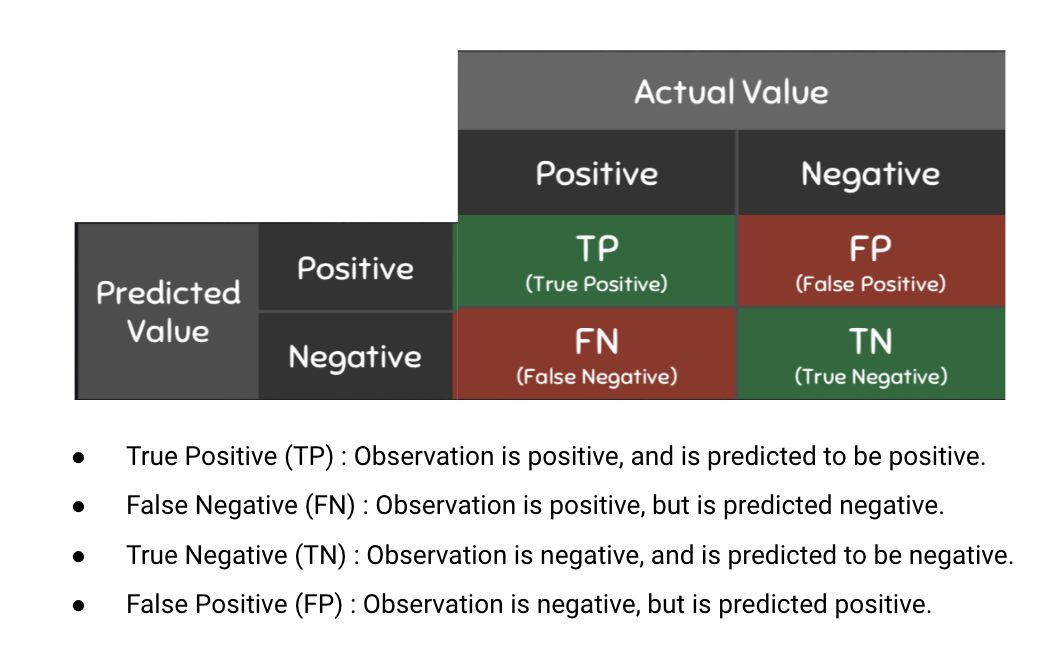

* **Accuracy**: How accurate the model classify to the right class (cautious with imbalance)
* **Precision**: More False Positive, the lower precision (False Positive is tolerant for high-risk problems, i.e. COVID diagnostic)
* **Recall (Sensitivity)**: More False Negative, the lower recall (False Negative is tolerant, Spam)
* **F1**: single score balances both the concerns of precision and recall. Good F1-score = low Precision, low Recall. Perfect = 1, Failure = 0
* **ROC Curve**: Plot of tpr (true positive rate) vs fpr (false positive rate) => Higher area under the curve better the models

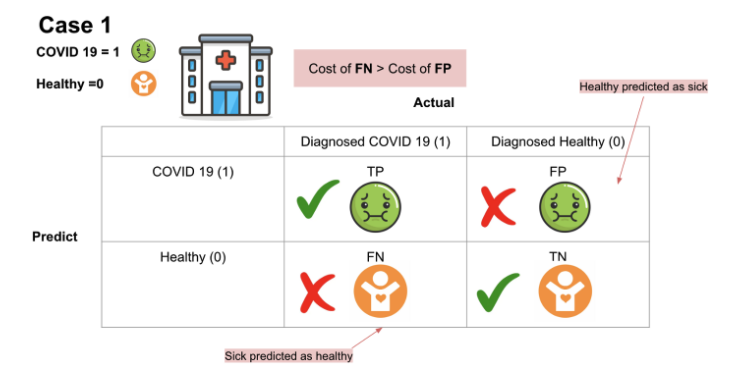

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [ ]:
def eval_class(true, predicted):
    acc = metrics.accuracy_score(true, predicted)
    precision = metrics.precision_score(true, predicted)
    recall = metrics.recall_score(true, predicted)
    f1 = metrics.f1_score(true, predicted)
    log_loss = metrics.log_loss(true, predicted)
    auc = metrics.roc_auc_score(true, predicted)
    return acc, precision, recall, f1, log_loss, auc

# ✔️ Model Explainer
* For Random Forest, GBM, XGBoost
* Rank the features by the importance to the model
* SHAP - SHApley Additive exPlanations ([HERE](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a))

In [ ]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [ ]:
import shap
# Summary bee-swarm plot to show the global importance of each features and distribution of effect size
def plot_shap_feature_importance(model, X, feature_names):
    shap_values = shap.TreeExplainer(xgb).shap_values(X)
    shap.summary_plot(shap_values, X, feature_names)
    
# Dependence Plot to investigate the interaction between features
def plot_shap_feature_interaction(model, X, feature_names, f_orders = (1,2)):
    shap_interaction_values = shap.TreeExplainer(xgb).shap_interaction_values(X)
    shap.dependence_plot(f_orders, shap_interaction_values, X,feature_names)

# 🧬 Linear Regressions
> * **Linear Asusumptions**: Relationship between your input and output is linear (`check by bins plot, transform: polynomial, absolute, log on exponential relationship`)
> * **Remove Noise**: Assume that input and output not noisy (`check by distribution plot, transform: Remove outliers on output/input if possible`)
> * **Remove Collinearity**: Over-fit the data when you add highly correlated input variables (`check by pairwise correlation`)
> * **Gaussian Distribution**: More reliable when input/output is gaussian distribution (`check by distribution, transform: Boxcox or log`)
> * **Rescale inputs**: rescale input variables using standardization/normalisation (`improve the above assumptions`)

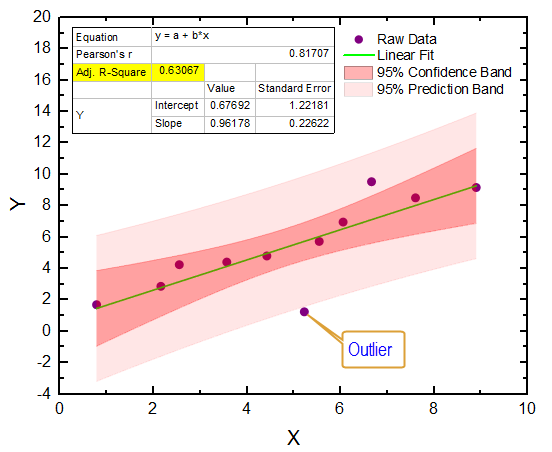

> **Reference:** [Linear Regressions House Price](https://www.kaggle.com/faressayah/linear-regression-house-price-prediction#%F0%9F%92%BE-Data)

## ✔️ Fitting

In [ ]:
from sklearn.linear_model import LinearRegression

# All features
lin_reg1 = LinearRegression(normalize=True)
lin_reg1.fit(X_train,y_train)

In [ ]:
# print the intercept
print(lin_reg1.intercept_)
coeff_df = pd.DataFrame(lin_reg1.coef_, X.columns, columns=['Coefficient'])
coeff_df.head()

## ✔️ Prediction

In [ ]:
pred = lin_reg1.predict(X_test)

plt.figure(figsize = (6,4))
sns.jointplot(x= y_test,y= pred,kind='reg')
#plt.title('Scatterplot between Y_test and Ytest_pred')
plt.grid()

In [ ]:
plt.figure(figsize = (15,6))
x_ax = range(len(X_test))
plt.plot(x_ax, y_test, lw=1, color="blue", label="original")
plt.plot(x_ax, pred, lw=0.8, color="red", label="predicted",marker="o", markersize=4)
plt.legend()
plt.grid()
plt.show()

## ✔️ Diagnostics

In [ ]:
sns.distplot((y_test - pred), bins=50);

In [ ]:
test_pred = lin_reg1.predict(X_test)
train_pred = lin_reg1.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

In [ ]:
eval_metrics = ['MAE', 'MSE', 'RMSE', 'R2_Square']
eval_m_train = [m + '_train' for m in eval_metrics]
eval_m_test = [m + '_test' for m in eval_metrics]
dis_m = ['Model','RMSE_train'] + eval_m_test + ['diff_RMSE_train_test']
results_df = pd.DataFrame(data=[["Linear Regression",*evaluate(y_train, train_pred),*evaluate(y_test, test_pred), cross_val(LinearRegression())]], 
                          columns=[['Model'] + eval_m_train + eval_m_test + ['CV']])
results_df['diff_RMSE_train_test'] = results_df.apply(lambda x: (x.RMSE_test - x.RMSE_train)/x.RMSE_train, axis=1)
results_df[dis_m]

## ✔️ Over-fitting
Below we also try the Linear Regression, but remove all categorical variables => Set-up: `Linear Regression - Numeric`.
Look into the report of evaluation:
* **Linear Regression (All Variables)**: RMSE in train is low but in test is higher (increase 28%) => Not stable, due to the overfiting (?) the performance in test is not great
* **Linear Regression (Numeric Variables)**: RMSE in train is higher than All variables but in test is RMSE is better (increase 3.8%) => More stable

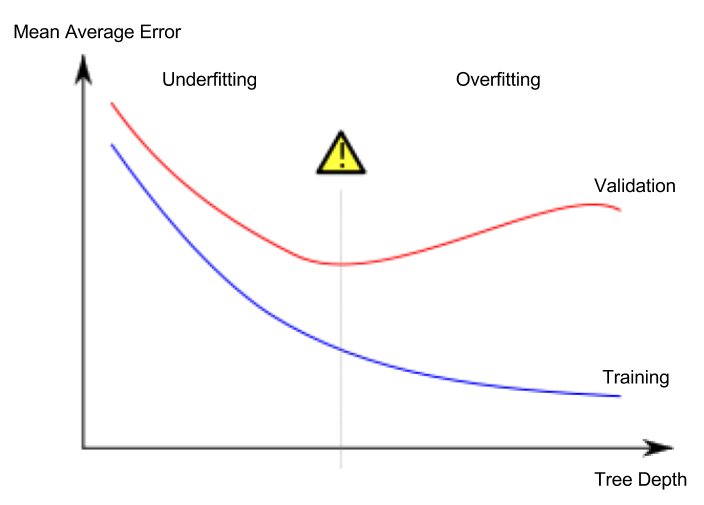

In [ ]:
# Try the model specifications to remove the cat variables
# All features
lin_reg2 = LinearRegression(normalize=True)
features_list = X.columns[:4]
lin_reg2.fit(X_train[:,:4],y_train) ## First 4 cols are numeric
# print the intercept
print(lin_reg2.intercept_)
coeff_df = pd.DataFrame(lin_reg2.coef_, features_list, columns=['Coefficient'])
coeff_df

In [ ]:
## Prediction
test_pred2 = lin_reg2.predict(X_test[:,:4])
train_pred2 = lin_reg2.predict(X_train[:,:4])

In [ ]:
## Evaluation
results_df2 = pd.DataFrame(data=[["Linear Regression - Numeric",*evaluate(y_train, train_pred2),*evaluate(y_test, test_pred2), 0]], 
                          columns=[['Model'] + eval_m_train + eval_m_test + ['CV']])
results_df2['diff_RMSE_train_test'] = results_df2.apply(lambda x: (x.RMSE_test - x.RMSE_train)/x.RMSE_train, axis=1)
results_df = results_df.append(results_df2, ignore_index=True)
results_df[dis_m]

## ✔️ Linear Regression with PCA

In [ ]:
## Fitting
lin_reg2b = LinearRegression(normalize=True)
lin_reg2b.fit(X_train_pca,y_train) ## First 4 cols are numeric

## Prediction
test_pred2b = lin_reg2b.predict(X_test_pca)
train_pred2b = lin_reg2b.predict(X_train_pca)

In [ ]:
## Evaluation
results_df2b = pd.DataFrame(data=[["Linear Regression - PCA",*evaluate(y_train, train_pred2b),*evaluate(y_test, test_pred2b), 0]], 
                          columns=[['Model'] + eval_m_train + eval_m_test + ['CV']])
results_df2b['diff_RMSE_train_test'] = results_df2b.apply(lambda x: (x.RMSE_test - x.RMSE_train)/x.RMSE_train, axis=1)
results_df = results_df.append(results_df2b, ignore_index=True)
results_df[dis_m]

# 🧬 Polynomial Regression
We can use linear model to trained nonlinear data. Linear model has the advantages of fast training, and fit a wide range of data.
Linear Regressions could be fitted on polynomial features to capture the non-linear relationship.
> **Reference:** 
> [ML Polynomial Regresison with Python](https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386)

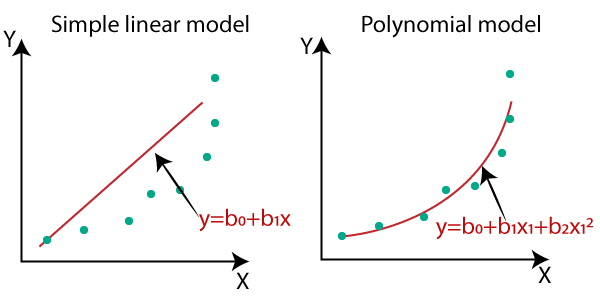

## ✔️ Data Processing

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
## Processing
poly_reg = PolynomialFeatures(degree=2)
X_train_2d = poly_reg.fit_transform(X_train[:,:4])
X_test_2d = poly_reg.transform(X_test[:,:4])
## Fitting
lin_reg3 = LinearRegression(normalize=True)
lin_reg3.fit(X_train_2d,y_train)
## Prediction
test_pred3 = lin_reg3.predict(X_test_2d)
train_pred3 = lin_reg3.predict(X_train_2d)

In [ ]:
## Evaluation
results_df3 = pd.DataFrame(data=[["Polynomial Regression",*evaluate(y_train, train_pred3),*evaluate(y_test, test_pred3), 0]], 
                          columns=[['Model'] + eval_m_train + eval_m_test + ['CV']])
results_df3['diff_RMSE_train_test'] = results_df3.apply(lambda x: (x.RMSE_test - x.RMSE_train)/x.RMSE_train, axis=1)
results_df = results_df.append(results_df3, ignore_index=True)
results_df[dis_m]

# 🧬 Support Vector Regressors
> **Reference**: [SVR - The most flexible yet robost prediction](https://towardsdatascience.com/support-vector-regression-svr-one-of-the-most-flexible-yet-robust-prediction-algorithms-4d25fbdaca60)

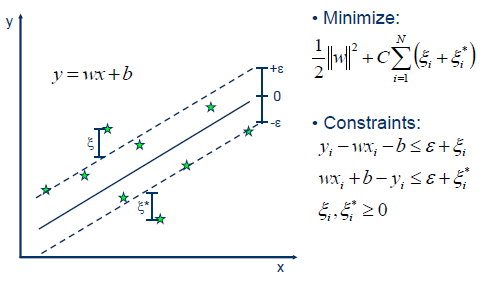

Source: [www.saedsayad.com/support_vector_machine_reg](https://www.saedsayad.com/support_vector_machine_reg.htm)

In [ ]:
from sklearn.svm import SVR # Support Vector Regression

## Fitting
svm_reg = SVR(kernel='rbf', C=1, epsilon=20)
svm_reg.fit(X_train[:,:4], y_train)
## Prediction
test_pred4 = svm_reg.predict(X_test[:,:4])
train_pred4 = svm_reg.predict(X_train[:,:4])

In [ ]:
## Evaluation
results_df4 = pd.DataFrame(data=[["SVM Regressor",*evaluate(y_train, train_pred4),*evaluate(y_test, test_pred4), 0]], 
                          columns=[['Model'] + eval_m_train + eval_m_test + ['CV']])
results_df4['diff_RMSE_train_test'] = results_df4.apply(lambda x: (x.RMSE_test - x.RMSE_train)/x.RMSE_train, axis=1)
results_df = results_df.append(results_df4, ignore_index=True)
results_df[dis_m]

In [ ]:
import plotly.graph_objects as go # for data visualization
import plotly.express as px # for data visualization
x_var = 'avg_session_length'
y_var = 'yearly_amount_spent'
# Note, we need X to be a 2D array, hence reshape
X=df_model[x_var].values.reshape(-1,1)
y=df_model[y_var].values
# ------- SVR vs. LR -------
lr = LinearRegression().fit(X, y)
svr = SVR(kernel='rbf', C=10, epsilon=20).fit(X, y)
# ------- Predict a range of values based on the models for visualization -------
# Create 100 evenly spaced points from smallest X to largest X
x_range = np.linspace(X.min(), X.max(), 100)
# Predict y values for our set of X values
y_lr = lr.predict(x_range.reshape(-1, 1)) # Linear regression
y_svr = lr.predict(x_range.reshape(-1, 1)) # SVR

fig = px.scatter(df_model, x=df_model[x_var], y=df_model[y_var], opacity=0.8, color_discrete_sequence=['black'])

# Add a best-fit line
fig.add_traces(go.Scatter(x=x_range, y=y_lr, name='Linear Regression', line=dict(color='limegreen')))
fig.add_traces(go.Scatter(x=x_range, y=y_svr, name='Support Vector Regression', line=dict(color='red')))
fig.add_traces(go.Scatter(x=x_range, y=y_svr+20, name='+epsilon', line=dict(color='red', dash='dot')))
fig.add_traces(go.Scatter(x=x_range, y=y_svr-20, name='-epsilon', line=dict(color='red', dash='dot')))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))
# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Set figure title
fig.update_layout(title=dict(text="Yearly Amount Spent Prediction", 
                             font=dict(color='black')))
# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()

# 🧬 Random Forest Regressor
**Random Forest** is an esemble of Decision Trees.
> **Reference**: [How to visualize a single Decision Tree from the RF in Python](https://mljar.com/blog/visualize-tree-from-random-forest/)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Fitting
rf_reg = RandomForestRegressor(n_estimators=1000, max_depth=3)
rf_reg.fit(X_train[:,:4], y_train)

# Prediction
test_pred5 = rf_reg.predict(X_test[:,:4])
train_pred5 = rf_reg.predict(X_train[:,:4])

## Evaluation
results_df5 = pd.DataFrame(data=[["RF Regressor",*evaluate(y_train, train_pred5),*evaluate(y_test, test_pred5), 0]], 
                          columns=[['Model'] + eval_m_train + eval_m_test + ['CV']])
results_df5['diff_RMSE_train_test'] = results_df5.apply(lambda x: (x.RMSE_test - x.RMSE_train)/x.RMSE_train, axis=1)
results_df = results_df.append(results_df5, ignore_index=True)
results_df[dis_m]

In [ ]:
plt.figure(figsize = (6,4))
plot_feature_importance(rf_reg.feature_importances_,['avg_session_length', 'time_on_app','time_on_website','length_of_membership'],'RF Regressors')

In [ ]:
!pip install dtreeviz

In [ ]:
from sklearn import tree
from dtreeviz.trees import dtreeviz # will be used for tree visualization
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.figsize': (10, 20)})
plt.rcParams.update({'font.size': 14})
viz = dtreeviz(rf_reg.estimators_[0], X_train[:,:4], y_train, feature_names=df_model.columns[:4], target_name="yearly_amount_spent")
viz

# 🧬 XGBoost Regressor

**XGBoost** goes through the modeling cycle for iterations, repeately bulding new models then combine them into an ensemble model.
* Start the cycle to calculate errors for each observations in dataset
* Build the next model to predict errors
* Add predictions from the error-predicting model to the "ensemble of models"

**Model Tuning**
Hyperparameters that dramatically affecy the accuracy and training speed:
* `n_estimators`: How many times to go through the modeling cycle. Too low `n_estimators`, model is underfitting (low accuracy in both training and testing). Typical range: 100-1000. Depends also on `learning_rate`.
* `early_stopping_rounds`: model stops iterating when validation score stops improving, even if we don't set `n_estimators`. If the value = 5, means we stop after 5 straight rounds that the validation score not improve.
* **==> Strategy**: Set high `n_estimators` and use `early_stopping_rounds` to find the optimal time to stop iterating (cautious with local optimum)
* `learning_rate`: instead of only adding up the predictions from new models, we multiply prediction by a small number before add up. This means the new tree/model add to the ensemble helps us less => Reduce the propensity of overfit (penalty the complexity). So that, we can have high `n_estimators` and control by this. But, it will take longer to train (more iterations)
* `n_jobs`: for large datasets, parallelism to build the model faster (n_jobs is the numbers of cores on the machines) => To speed up modeling time.
> **Reference**: [XGBoost Kaggle Tutorial ](https://www.kaggle.com/dansbecker/xgboost)

In [ ]:
from xgboost import XGBRegressor
from xgboost import plot_importance
## Fitting
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05)
# Add silent=True to avoid printing out updates with each cycle
xgb.fit(X_train[:,:4], y_train, early_stopping_rounds=5, eval_set=[(X_test[:,:4], y_test)], verbose=False)
# Prediction
test_pred6 = xgb.predict(X_test[:,:4])
train_pred6 = xgb.predict(X_train[:,:4])

## Evaluation
results_df6 = pd.DataFrame(data=[["XGB Regressor",*evaluate(y_train, train_pred6),*evaluate(y_test, test_pred6), 0]], 
                          columns=[['Model'] + eval_m_train + eval_m_test + ['CV']])
results_df6['diff_RMSE_train_test'] = results_df5.apply(lambda x: (x.RMSE_test - x.RMSE_train)/x.RMSE_train, axis=1)
results_df = results_df.append(results_df6, ignore_index=True)
results_df[dis_m]

In [ ]:
xgb.feature_names = ['avg_session_length', 'time_on_app','time_on_website','length_of_membership']
plt.figure(figsize = (15,6))
plot_feature_importance(xgb.feature_importances_, xgb.feature_names, 'XGB')

In [ ]:
feature_names = ['avg_session_length', 'time_on_app','time_on_website','length_of_membership']
plot_shap_feature_importance(xgb, X_test[:,:4], feature_names)

In [ ]:
plot_shap_feature_interaction(xgb, X_test[:,:4],['avg_session_length', 'time_on_app','time_on_website','length_of_membership'], (3,0))

# 📈 Regressors Comparison

In [ ]:
results_df[dis_m]

# 🧬 Decision Tree Classifier
> Source: [scikit-learn.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

**Parameters:**
* `criterion{“gini”, “entropy”}, default=”gini”`: Function to measure the quality of split
* `max_depth`: how many layers the tree has (to avoid too complex tree => overfitting)
* `min_samples_split`: minimum numbers of samples for each split (to avoid splitting to too small groups => overfitting)
* `min_samples_leaft`: minimum numbers of samples for each leaf node (to avoid splitting to too small groups => overfitting)
* `min_impurity_decrease`: early stops the tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
clf = DecisionTreeClassifier(random_state=1234, max_depth=3)
clf_model = clf.fit(X_train[:,:4], y_class_train)

In [ ]:
plot_feature_importance(clf_model.feature_importances_,['avg_session_length', 'time_on_app','time_on_website','length_of_membership'],'Decision Tree Classifier')

In [ ]:
viz = dtreeviz(clf, X_train[:,:4], y_class_train,
                target_name='is_highval',
                feature_names=['avg_session_length','time_on_app','time_on_website','length_of_membership'],
                class_names=[0,1])

viz

In [ ]:
# Prediction
test_pred_class1 = clf_model.predict(X_test[:,:4])
train_pred_class1 = clf_model.predict(X_train[:,:4])
# Confusion Matrix
metrics.confusion_matrix(test_pred_class1, y_class_test)

In [ ]:
eval_clm_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Log_loss','AUC']
eval_clm_train = [m + '_train' for m in eval_clm_metrics]
eval_clm_test = [m + '_test' for m in eval_clm_metrics]
dis_clm = ['Model','Accuracy_train'] + eval_clm_test + ['diff_Acc_train_test']
res_clm = pd.DataFrame(data=[["Decision Tree Classifier",*eval_class(y_class_train, train_pred_class1),
                                 *eval_class(y_class_test, test_pred_class1)]],
                          columns=[['Model'] + eval_clm_train + eval_clm_test])
res_clm['diff_Acc_train_test'] = res_clm.apply(lambda x: (x.Accuracy_test - x.Accuracy_train)/x.Accuracy_train, axis=1)
res_clm[dis_clm]

# 🧬 Logit Regression

In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Technique for tunning the model

# Training
logit_model = LogisticRegression(random_state=5, class_weight='balanced')
logit_model = logit_model.fit(X_train[:,:4], y_class_train)

# Prediction
test_pred_class2 = logit_model.predict(X_test[:,:4])
train_pred_class2 = logit_model.predict(X_train[:,:4])
# Confusion Matrix
metrics.confusion_matrix(test_pred_class2, y_class_test)

In [ ]:
# Evaluation on Train & Test set
res_clm2 = pd.DataFrame(data=[["Logistic Model",*eval_class(y_class_train, train_pred_class2),
                                 *eval_class(y_class_test, test_pred_class2)]],
                          columns=[['Model'] + eval_clm_train + eval_clm_test])
res_clm2['diff_Acc_train_test'] = res_clm2.apply(lambda x: (x.Accuracy_test - x.Accuracy_train)/x.Accuracy_train, axis=1)
res_clm = res_clm.append(res_clm2, ignore_index=True)
res_clm[dis_clm]

# 🧬 GBM Classifier
> **Reference**
> * [Gradient Boosting with Scikit-Learn](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/)
> * [scikit-learn.GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

**Parameters:**
* `loss{‘deviance’, ‘exponential’}, default=’deviance’`: Loss function to be optimized (Deviance = logit)
* `learning_rate`: shrunks the contribution of each tree (trade off between n_estimators and learning_date)
* `n_estimators`: Number of boosting stage (GB fairly robust to over-fitting => large number can boost the performance)
* `max_depth`, `min_impurity_decrease`

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Training
gbm_cmodel = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01)
gbm_cmodel = gbm_cmodel.fit(X_train[:,:4], y_class_train)

# Prediction
test_pred_class3 = gbm_cmodel.predict(X_test[:,:4])
train_pred_class3 = gbm_cmodel.predict(X_train[:,:4])

# Confusion Matrix
metrics.confusion_matrix(test_pred_class3, y_class_test)

In [ ]:
# Evaluation on Train & Test set
res_clm3 = pd.DataFrame(data=[["GBM Classifier",*eval_class(y_class_train, train_pred_class3),
                                 *eval_class(y_class_test, test_pred_class3)]],
                          columns=[['Model'] + eval_clm_train + eval_clm_test])
res_clm3['diff_Acc_train_test'] = res_clm3.apply(lambda x: (x.Accuracy_test - x.Accuracy_train)/x.Accuracy_train, axis=1)
res_clm = res_clm.append(res_clm3, ignore_index=True)
res_clm[dis_clm]

# 🧬 LightGBM Classifier

In [ ]:
from lightgbm import LGBMClassifier

# Training
lgbm_cmodel = LGBMClassifier()
lgbm_cmodel = lgbm_cmodel.fit(X_train[:,:4], y_class_train)

# Prediction
test_pred_class4 = lgbm_cmodel.predict(X_test[:,:4])
train_pred_class4 = lgbm_cmodel.predict(X_train[:,:4])
# Confusion Matrix
metrics.confusion_matrix(test_pred_class4, y_class_test)

In [ ]:
# Evaluation on Train & Test set
res_clm4 = pd.DataFrame(data=[["LightGBM Classifier",*eval_class(y_class_train, train_pred_class4),
                                 *eval_class(y_class_test, test_pred_class4)]],
                          columns=[['Model'] + eval_clm_train + eval_clm_test])
res_clm4['diff_Acc_train_test'] = res_clm4.apply(lambda x: (x.Accuracy_test - x.Accuracy_train)/x.Accuracy_train, axis=1)
res_clm = res_clm.append(res_clm4, ignore_index=True)
res_clm[dis_clm]

# 🧬 XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier

## Fitting
xgb_cmodel = XGBClassifier(n_estimators=1000, learning_rate=0.05)
# Add silent=True to avoid printing out updates with each cycle
xgb_cmodel.fit(X_train[:,:4], y_class_train, early_stopping_rounds=5, eval_set=[(X_test[:,:4], y_class_test)], verbose=False)

# Prediction
test_pred_class5 = xgb_cmodel.predict(X_test[:,:4])
train_pred_class5 = xgb_cmodel.predict(X_train[:,:4])
# Confusion Matrix
metrics.confusion_matrix(test_pred_class5, y_class_test)

In [ ]:
# Evaluation on Train & Test set
res_clm5 = pd.DataFrame(data=[["XGBoost Classifier",*eval_class(y_class_train, train_pred_class5),
                                 *eval_class(y_class_test, test_pred_class5)]],
                          columns=[['Model'] + eval_clm_train + eval_clm_test])
res_clm5['diff_Acc_train_test'] = res_clm5.apply(lambda x: (x.Accuracy_test - x.Accuracy_train)/x.Accuracy_train, axis=1)
res_clm = res_clm.append(res_clm5, ignore_index=True)
res_clm[dis_clm]

# 🧬 RF Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

## Fitting
rf_cmodel = RandomForestClassifier(n_estimators=1000, max_depth=3)
# Add silent=True to avoid printing out updates with each cycle
rf_cmodel.fit(X_train[:,:4], y_class_train)

# Prediction
test_pred_class6 = rf_cmodel.predict(X_test[:,:4])
train_pred_class6 = rf_cmodel.predict(X_train[:,:4])
# Confusion Matrix
metrics.confusion_matrix(test_pred_class6, y_class_test)

In [ ]:
# Evaluation on Train & Test set
res_clm6 = pd.DataFrame(data=[["RF Classifier",*eval_class(y_class_train, train_pred_class6),
                                 *eval_class(y_class_test, test_pred_class6)]],
                          columns=[['Model'] + eval_clm_train + eval_clm_test])
res_clm6['diff_Acc_train_test'] = res_clm6.apply(lambda x: (x.Accuracy_test - x.Accuracy_train)/x.Accuracy_train, axis=1)
res_clm = res_clm.append(res_clm6, ignore_index=True)
res_clm[dis_clm]

# 🧬 Naive Bayes
> **Source**: [Naive Bayers Classifier from Scratch Python](https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/)

Naive Bayes methods are base on Bayes' theorem with the "naive" assumption of conditional independece between every pair of featrues given the class variables. 
Despite the over-simplified assumptions, Naive Bayers worked quite well in many real-world situations (famous for document classification and spam filtering). 
* Require a small amout of training data
* Fast training comparing to sophisticated methods

In [ ]:
from sklearn.naive_bayes import GaussianNB

## Fitting
nb_cmodel = GaussianNB()
# Add silent=True to avoid printing out updates with each cycle
nb_cmodel.fit(X_train[:,:4], y_class_train)

# Prediction
test_pred_class7 = nb_cmodel.predict(X_test[:,:4])
train_pred_class7 = nb_cmodel.predict(X_train[:,:4])
# Confusion Matrix
metrics.confusion_matrix(test_pred_class7, y_class_test)

In [ ]:
# Evaluation on Train & Test set
res_clm7 = pd.DataFrame(data=[["NBayes Classifier",*eval_class(y_class_train, train_pred_class7),
                                 *eval_class(y_class_test, test_pred_class7)]],
                          columns=[['Model'] + eval_clm_train + eval_clm_test])
res_clm7['diff_Acc_train_test'] = res_clm7.apply(lambda x: (x.Accuracy_test - x.Accuracy_train)/x.Accuracy_train, axis=1)
res_clm = res_clm.append(res_clm7, ignore_index=True)
res_clm[dis_clm]

# 📈 Classifiers Comparison

In [ ]:
res_clm[dis_clm]

In [ ]:
#Predicting proba
ytest_pred_prob1 = clf_model.predict_proba(X_test[:,:4])[:,1]
ytest_pred_prob2 = logit_model.predict_proba(X_test[:,:4])[:,1]
ytest_pred_prob3 = gbm_cmodel.predict_proba(X_test[:,:4])[:,1]
ytest_pred_prob4 = lgbm_cmodel.predict_proba(X_test[:,:4])[:,1]
ytest_pred_prob5 = xgb_cmodel.predict_proba(X_test[:,:4])[:,1]
ytest_pred_prob6 = rf_cmodel.predict_proba(X_test[:,:4])[:,1]
ytest_pred_prob7 = nb_cmodel.predict_proba(X_test[:,:4])[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_class_test, ytest_pred_prob1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_class_test, ytest_pred_prob2)
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_class_test, ytest_pred_prob3)
fpr4, tpr4, thresholds4 = metrics.roc_curve(y_class_test, ytest_pred_prob4)
fpr5, tpr5, thresholds5 = metrics.roc_curve(y_class_test, ytest_pred_prob5)
fpr6, tpr6, thresholds6 = metrics.roc_curve(y_class_test, ytest_pred_prob6)
fpr7, tpr7, thresholds7 = metrics.roc_curve(y_class_test, ytest_pred_prob7)

# Plot ROC curve
plt.figure(figsize = (15,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)
plt.plot(fpr4, tpr4)
plt.plot(fpr5, tpr5)
plt.plot(fpr6, tpr6)
plt.plot(fpr7, tpr7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: High-Value Users Classifiers')
plt.legend(['Baseline','DecisionTreeClassifier','Logit','GBM', 'LightGBM', 'XGBoost', 'RF','Naive Bayes'], loc='lower right')
plt.show()

# Reference
1. [Predicting Credit Risk - Model Pipeline](https://www.kaggle.com/kabure/predicting-credit-risk-model-pipeline): A notebook with ML pipeline for classification
2. [k-mean Clustering Pipeline](https://realpython.com/k-means-clustering-python/): Pipeline in using clustring, and PCA to processing data